# Quantum Phase Estimation

They theory of Quantum Phase Estimation will be covered in the book.  However, there are numerous resources online that cover the theory in detail.  This covers the implementation and notes several pitfals for new programmers -- namely in how various algorithums use slightly different versions of the Quantum Fourier Transformation. Two implementation are demonstrated here, but many more exist.  Which one you use depends on what you are trying to do inside your circuit.  The "textbook" definition is easiest for beginers to follow along with, but because of the number of gates used, it is rarely actually used in any of the larger alrogithums. 

Note that Qiskit stores its matricies in "reverse" order, and the learn_quantum library displays them in "normal" order so they match up with textbooks and academic papers.

In [1]:
import numpy as np

from math import ceil, sqrt, log2
from random import randint

from fractions import Fraction

from qiskit.visualization import plot_histogram
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
import learn_quantum as lq
from learn_quantum import imag, ket, bra, np_array_to_latex as a_to_l
from IPython.display import Latex
import numpy as np
from numpy import pi, cos, sin, exp, gcd, lcm, pi as π

import matplotlib.pyplot as plt

In [2]:
def textbook_qft(qr, cr, bit_size):

    circuit = QuantumCircuit(qr, cr)
    
    for j in range(bit_size):
        circuit.h(qr[j])
        for k in range(1, bit_size-j):
            angle = π/(2**k)
            circuit.cu1(angle, qr[k+j], qr[j])
            
    for i in range(bit_size//2):
        circuit.swap(qr[i], qr[bit_size-i-1])
    
    return circuit


def textbook_qft_no_swap(qr, cr, n, start_at=0):
    circuit = QuantumCircuit(qr, cr)

    for j in range(n + start_at):
        circuit.h(qr[j])
        for k in range(j + 1 + start_at, n + start_at):
            circuit.cu1(np.pi/float(2**(k-j)), qr[k], qr[j])
    return circuit


def signal_qft(qr, cr ,n, start_at=0):
    circuit = QuantumCircuit(qr, cr)

    for k in range(n + start_at):
        j = n - k
        circuit.h(qr[j-1])
        for i in reversed(range(j-1)):
            circuit.cu1(2*np.pi/2**(j-i),qr[i], qr[j-1])

    for i in range(n//2):
        circuit.swap(qr[i], qr[n-i-1])
    return circuit

def np_textbook_qft_matrix(size):
    if size > 12:
        print('Too large.')
        return
    
    qft = np.zeros([2**size, 2**size], dtype=complex)
    omega = exp(2*π*lq.imag/(2**size))
    for m in range(2**size):
        for n in range(2**size):
            qft[m, n] = omega**(n*m)
    return 1/sqrt(2**size)*qft

In [3]:
def input_state(circ, q, value_to_encode, size ):
    for bit in range(size):
        circ.rz(value_to_encode*float(π)/(2**bit), q[size-1-bit])

In [4]:
size = 3
value_to_encode = 2

q = QuantumRegister(size)
c = ClassicalRegister(size)

initial_qft = QuantumCircuit(q, c)
initial_qft.h(q)

signal = QuantumCircuit(q, c)
input_state(signal, q, value_to_encode, size)

inverse_qft = signal_qft(q, c, size).inverse()

m = QuantumCircuit(q, c)
m.measure(q,c)



In [5]:
shots = 1000
answers = lq.execute_simulated(initial_qft + signal + inverse_qft + m ,shots)
lq.print_reverse_results(answers, label='Direct Signal')
for key in answers:
    print(int(key,2))

Reversed:Direct Signal: [('010', 1000)]
2


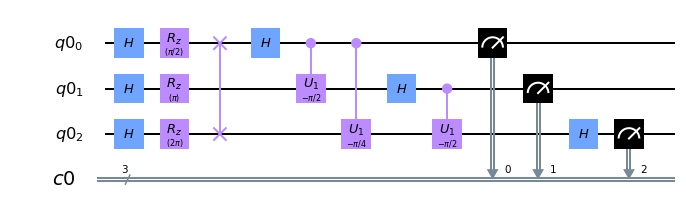

In [6]:
(initial_qft + signal + inverse_qft + m).draw(output='mpl')

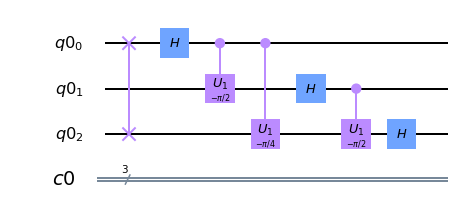

In [7]:
(inverse_qft).draw(output='mpl')

# Generate a Standard QFT and compare it to the textbook definition

In [8]:
size=2
q2= QuantumRegister(size)
c2 = ClassicalRegister(size)

s_qft = textbook_qft(q2, c2, size)

lq.show_me_the_matrix(s_qft, normalize=True, display_exp=True)

<IPython.core.display.Latex object>

In [9]:
Latex(a_to_l(np_textbook_qft_matrix(2), display_exp=True))

<IPython.core.display.Latex object>

In [10]:
lq.show_me_the_matrix(s_qft, normalize=True, display_omega=True)

<IPython.core.display.Latex object>

In [22]:
Latex(a_to_l(np_textbook_qft_matrix(3), normalize=True, display_exp=True))

<IPython.core.display.Latex object>

In [12]:
size=3
q2= QuantumRegister(size)
c2 = ClassicalRegister(size)

s_qft = textbook_qft(q2, c2, size)

lq.show_me_the_matrix(s_qft, normalize=True, display_exp=True)

<IPython.core.display.Latex object>

In [13]:
lq.show_me_the_matrix(s_qft, normalize=True, display_omega=True)

<IPython.core.display.Latex object>

In [18]:
Latex(lq.np_array_to_latex(np_textbook_qft_matrix(4), normalize=True, display_omega=True))

<IPython.core.display.Latex object>

In [22]:
size=4
q2= QuantumRegister(size)
c2 = ClassicalRegister(size)

s_qft = textbook_qft(q2, c2, size)

lq.show_me_the_matrix(s_qft, normalize=True, display_omega=True)

<IPython.core.display.Latex object>

Verify that the "signal" QFT tranformation is different, although with the proper circuit it can achieve the same type of result.

In [27]:
N=3
q2= QuantumRegister(3)
c2 = ClassicalRegister(3)

s_qft = signal_qft(q2, c2, N)

lq.show_me_the_matrix(s_qft, normalize=True, display_exp=True)

<IPython.core.display.Latex object>

# QFT applied to the Zero state is the same as applying Hadamards
Because the Quantum Circuit is initialized in the '0000...' state, applying a QFT to that state is the same as applying exclusively Hadamards.  You can see this from the above matricies, but we verify it below. 

As such, the initial applications of Hadamards is really a "QFT" -- which is why it was labeled as such above.  Thus, you perform a "QFT" on the zero state, then apply a signal, then apply a inverse QFT.  To save on gate counts, this is the same as applying Hadamards to all the initial states, then the signal then the inverse QFT.

In [28]:
Latex(a_to_l(np_textbook_qft_matrix(3)@ket('000')))

<IPython.core.display.Latex object>

In [29]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr, cr)
qc.h(qr)


In [30]:
hadamard_qft = lq.what_is_the_matrix(qc)

In [31]:
Latex(a_to_l(hadamard_qft))

<IPython.core.display.Latex object>

In [32]:
Latex(a_to_l(hadamard_qft@ket('000')))

<IPython.core.display.Latex object>

## Exercise: Verify that applying the full "QFT" circuit to the inital state acheives identical results

In [33]:
size = 3
value_to_encode = 3

q = QuantumRegister(size)
c = ClassicalRegister(size)

#You can use either textbook or signal, result is the same
initial_qft = textbook_qft(q, c, size) 

signal = QuantumCircuit(q, c)
input_state(signal, q, value_to_encode, size)

inverse_qft = signal_qft(q, c, size).inverse()

m = QuantumCircuit(q, c)
m.measure(q,c)

In [34]:
shots = 1000
answers = lq.execute_simulated(initial_qft + signal + inverse_qft + m ,shots)
lq.print_reverse_results(answers, label='Direct Signal')
for key in answers:
    print(int(key,2))

Reversed:Direct Signal: [('110', 1000)]
3


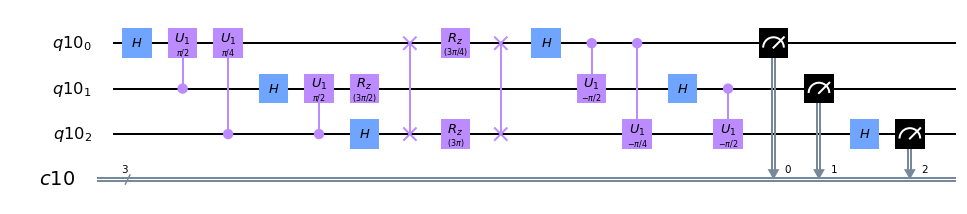

In [35]:
(initial_qft + signal + inverse_qft + m).draw(output='mpl')

## Exercise:  Implement a smaller circuit by removing the swap gates

In many implementations of Shor's algorithum, a simplified QFT type operation is used to reduce the gate counts.  Swap gates are decomposed to three control-not gates which are "expensive" gates.  Rewrite the code to remove the swap gates.  There are different ways to do this, but you want a circuit that has has few gates as possible.  So, of course, use the Hadamards as QFT on the zero state.

In [ ]:
# You can either re-implement this function or put all the logic into the QFT.
# These functions should be substantially similar to the originals in size and complexity. 
# If you have a 10 line fucntion, you have taken a wrong turn.

def input_no_swap(signal_no_swap, q, value_to_encode, size):
    # TODO: Your code
    
    
def signal_qft_no_swap(q, c, size):
    #TODO: Your code
    
    

In [ ]:
size = 3
value_to_encode = 3

q = QuantumRegister(size)
c = ClassicalRegister(size)

initial_qft = QuantumCircuit(q, c)
initial_qft.h(q)

signal_no_swap = QuantumCircuit(q, c)

input_no_swap(signal_no_swap, q, value_to_encode, size)

inverse_qft_no_swap = signal_qft_no_swap(q, c, size)

m = QuantumCircuit(q, c)
m.measure(q,c)

In [ ]:
shots = 1000
answers = lq.execute_simulated(initial_qft + signal_no_swap + inverse_qft_no_swap + m ,shots)
lq.print_reverse_results(answers, label='Direct Signal')
for key in answers:
    print(int(key,2))

# Exact phase measurement.

The following implements the "textbook" version of Quantum Phase Estimation starting with exact measurement.

When the input phase is a direct multiple of the precission, it is meaured directly and no estimation is needed.  That is, if we input a phase of 1/4π into a 2 qubit system, it can measure that directly and return an exact result.  We will start with exact measurement and then extend it to estimation.

The first implementation uses multiple qubits to hold the phase and you adjust the phase by turning off or on the various input qubits. 

The next implementation uses a single qubit to hold the phase and you adjust the phase by changing the circuit -- this is the way most implmentations of Shors do it.  

Finally, the phase estimation circuit uses continued fractions post-measurement to estimate phases between precission levels. 

In [36]:
qr = QuantumRegister(6)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr, cr)

qc.h(qr[0])
qc.h(qr[1])
qc.h(qr[2])

## Comment and uncomment these qubits to set the phase
## These are considered the "inputs"
#qc.x(qr[3])
qc.x(qr[4])
#qc.x(qr[5])

angle = np.pi/4

qc.cu1(angle, qr[2], qr[3])
qc.cu1(2*angle, qr[1], qr[3])
qc.cu1(4*angle, qr[0], qr[3])

qc.cu1(2*angle, qr[2], qr[4])
qc.cu1(4*angle, qr[1], qr[4])

qc.cu1(4*angle, qr[2], qr[5])

# You can generate the QFT and then invert when your measure
qft = textbook_qft(qr, cr, 3)

m = QuantumCircuit(qr, cr)
m.measure(qr[0], cr[0])
m.measure(qr[1], cr[1])
m.measure(qr[2], cr[2])


In [37]:
shots = 1000
answers = lq.execute_simulated(qc+qft.inverse()+m ,shots)
lq.print_reverse_results(answers, label='QPE')
for key in answers:
    print(int(key[::-1],2), answers[key])

Reversed:QPE: [('010', 1000)]
2 1000


# Qiskit Version with no swap gates

If you use the Qiskit native way of storing, you do not need the swap gates and you do not need to reverse the output.

However, when you compare your circuits to textbook circuits, they will appear "backwards." 


In [38]:
qr = QuantumRegister(6)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr, cr)

qc.h(qr[0])
qc.h(qr[1])
qc.h(qr[2])

## Comment and uncomment these qubits to set the phase
## These are considered the "inputs"
qc.x(qr[3])
#qc.x(qr[4])
#qc.x(qr[5])

angle = np.pi/4

qc.cu1(angle, qr[0], qr[5])
qc.cu1(2*angle, qr[1], qr[5])
qc.cu1(4*angle, qr[2], qr[5])

qc.cu1(2*angle, qr[0], qr[4])
qc.cu1(4*angle, qr[1], qr[4])

qc.cu1(4*angle, qr[0], qr[3])

# You can generate the QFT and then invert when your measure
qft = textbook_qft_no_swap(qr, cr, 3)

m = QuantumCircuit(qr, cr)
m.measure(qr[0], cr[0])
m.measure(qr[1], cr[1])
m.measure(qr[2], cr[2])

In [39]:
shots = 1000
answers = lq.execute_simulated(qc+qft.inverse()+m ,shots)
lq.print_reverse_results(answers, integer=True)

Reversed: [(4, 1000)]


# But the matrix does not match the standard definitions

While the computations are identical, the different ways of storing the data can be very confusing.  It is best to write your implementation using the standard "textbook" formats and then go back and optimize the code for Qiskit.  In addition, if you are porting to other platforms, any platform can run the "textbook" verions.

In [40]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr, cr)

qft = textbook_qft_no_swap(qr, cr, 3)

qiskit_qft = lq.execute_unitary(qft)
Latex(a_to_l(qiskit_qft, normalize=True, display_exp=True))

<IPython.core.display.Latex object>

# Change the phase by changing the circuit

In [41]:
def generate_rotation_circuit(qr, cr, angle):
    qc_rotation = QuantumCircuit(qr, cr)
    qc_rotation.cu1(angle, qr[2], qr[3])
    qc_rotation.cu1(2*angle, qr[1], qr[3])
    qc_rotation.cu1(4*angle, qr[0], qr[3])
    
    return qc_rotation

In [42]:
qr = QuantumRegister(4)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr, cr)

qc.h(qr[0])
qc.h(qr[1])
qc.h(qr[2])
qc.x(qr[3])

## Just outlining it here, it will be generated below
angle = 2*π/4
qc_rotation = generate_rotation_circuit(qr, cr, angle)

qft_inverse = textbook_qft(qr, cr, 3).inverse()

m = QuantumCircuit(qr, cr)
m.measure(qr[0], cr[0])
m.measure(qr[1], cr[1])
m.measure(qr[2], cr[2])

In [43]:
shots = 1000
for k in range(8):
    angle = k*π/4
    qc_rotation = generate_rotation_circuit(qr, cr, angle)
    answers = lq.execute_simulated(qc+qc_rotation+qft_inverse+m ,shots)
    lq.print_reverse_results(answers)
    lq.print_reverse_results(answers, integer=True, label='Integer')
    print('------------------------')

Reversed: [('000', 1000)]
Reversed:Integer: [(0, 1000)]
------------------------
Reversed: [('001', 1000)]
Reversed:Integer: [(1, 1000)]
------------------------
Reversed: [('010', 1000)]
Reversed:Integer: [(2, 1000)]
------------------------
Reversed: [('011', 1000)]
Reversed:Integer: [(3, 1000)]
------------------------
Reversed: [('100', 1000)]
Reversed:Integer: [(4, 1000)]
------------------------
Reversed: [('101', 1000)]
Reversed:Integer: [(5, 1000)]
------------------------
Reversed: [('110', 1000)]
Reversed:Integer: [(6, 1000)]
------------------------
Reversed: [('111', 1000)]
Reversed:Integer: [(7, 1000)]
------------------------


# Phase Estimation
The circuit will use a single qubit to hold an arbitrary phase. The QFT will map that phase onto only 3 qubits.  Unless the phase is an exact multiple of $\frac{2\pi}{8} = \frac{\pi}{4}$, the phase needs to be estimated by looking at the values returned. 

In [126]:
def combine_results(answers):
    combined = 0
    total = 0
    for key in answers:
        key_count = answers[key]
        total = total + key_count

    for key in answers:
        key_count = answers[key]
        ## a binary decimal for the full string is just to divide by 2**max bit size
        ## so '001' is 1/8. '0010' is 3/16... 
        binary_decimal = int(key[::-1],2)/(2**len(key))
        ## combine together as weighted average
        ## each result is given the weight of its percetage of the total.
        combined = combined + (key_count/total)*binary_decimal
    return combined


In [127]:
qr = QuantumRegister(4)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr, cr)

qc.h(qr[0])
qc.h(qr[1])
qc.h(qr[2])
qc.x(qr[3])


angle = 5*π/8

qc.cu1(angle, qr[2], qr[3])
qc.cu1(2*angle, qr[1], qr[3])
qc.cu1(4*angle, qr[0], qr[3])



qft = textbook_qft(qr, cr, 3)

m = QuantumCircuit(qr, cr)
m.measure(qr[0], cr[0])
m.measure(qr[1], cr[1])
m.measure(qr[2], cr[2])



In [128]:
shots = 1000
answers = lq.execute_simulated(qc+qft.inverse()+m ,shots)
lq.print_reverse_results(answers, label='QPE')
lq.print_reverse_results(answers, label='QPE-Integer', integer=True)


print('--------------------')
estimate = combine_results(answers)
print('Estimated Phase:', estimate)
print('Actual:', angle/(2*π))
print('As fraction:', Fraction(estimate).limit_denominator(16))
print('Actual:', Fraction(angle/(2*π)).limit_denominator(16))

Reversed:QPE: [('000', 23), ('001', 63), ('010', 403), ('011', 418), ('100', 39), ('101', 22), ('110', 16), ('111', 16)]
Reversed:QPE-Integer: [(0, 23), (1, 63), (2, 403), (3, 418), (4, 39), (5, 22), (6, 16), (7, 16)]
--------------------
Estimated Phase: 0.32462500000000005
Actual: 0.3125
As fraction: 1/3
Actual: 5/16


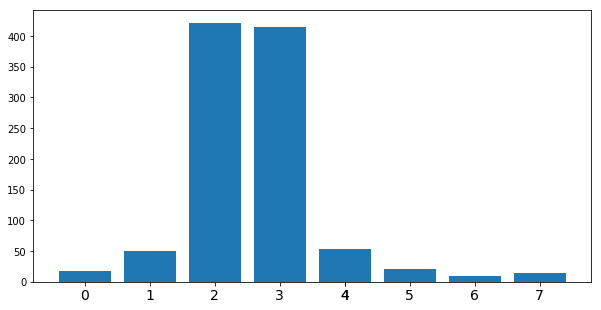

In [108]:
lq.plot_results(answers, spacing=0)

The above code averages over a series of runs, but you can see that using the continued fraction approach, the result from a single run is very close to the actual phase.

As a practical matter, any quantum made today will run 1000 shots in not much more time than running 1 shot so this is of little immediate use.  However, assuming some larger quantum computers, it might be impractical to run hundred or thousands of times.  Using the phase estimation technique, you get a "close" estimation with high probability. 

In [109]:
shots = 1
answers = lq.execute_simulated(qc+qft.inverse()+m ,shots)
lq.print_reverse_results(answers, label='QPE')
for key in answers:
    print(int(key[::-1],2), answers[key])
print('--------------------')
estimate = combine_results(answers)
print('Estimated Phase:', estimate)
print('Actual:', angle/(2*π))
print('As fraction:', Fraction(estimate).limit_denominator(16))
print('Actual:', Fraction(angle/(2*π)).limit_denominator(16))

Reversed:QPE: [('011', 1)]
3 1
--------------------
Estimated Phase: 0.375
Actual: 0.3125
As fraction: 3/8
Actual: 5/16


## Exercise: What does the state look like without performing the inverse QFT

In [57]:
shots = 1000
answers = lq.execute_simulated(qc+m ,shots)



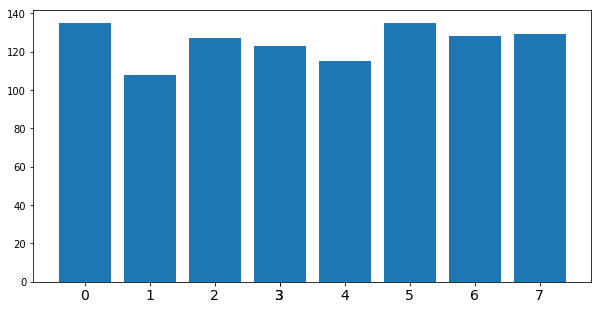

In [58]:
lq.plot_results(answers, spacing=0)

In [59]:
Latex(lq.show_state_vector(qc))

<IPython.core.display.Latex object>

## Exercise:  Implement an arbitrary bit precission estimation circuit

That is, input a precission bit size for phase estimation.  For hints, see the Reference Implementation of Shor's. 

## Reuse single qubit for phase estimation

In [171]:
def rotate_phase(rotate_angle, qr, cr):
    rotation = QuantumCircuit(qr, cr)
    rotation.cu1(rotate_angle, qr[0], qr[1])
    return rotation

qr = QuantumRegister(2)
cr = ClassicalRegister(1)
initial = QuantumCircuit(qr, cr)

initial.h(qr[0])
initial.x(qr[1])


angle = 2 * (15*π/32)

final = QuantumCircuit(qr, cr)
final.h(qr[0])

m = QuantumCircuit(qr, cr)
m.measure(qr[0], cr[0])


shots = 1
binary_phase = ''
for k in range(5):
    rotation = rotate_phase(angle*(2**k), qr, cr)
    
    answers = lq.execute_simulated(initial+rotation+final+m ,shots)
    binary_phase = next(iter(answers)) + binary_phase # reverse order

binary_decimal = int(binary_phase,2)/(2**len(binary_phase))

print('Actual:', Fraction(angle/(2*π)).limit_denominator(32))
print('Estimate As fraction:', Fraction(binary_decimal).limit_denominator(32))

10001
Actual: 15/32
Estimate As fraction: 17/32
